In this notebook, I will demonstrate how to use existing SDSS software to create a desired commissioning carton and then creat FPS designs from that carton. In this example, I will specifically creating a design that includes spectrophotometric standards, skies and other standards. This example will be a more complex design, so if you need to look at a more straightforward example, please look at the example of creating an all-sky carton.

# Commissioning Carton Creation

If you have a set of targets with known IDs (Gaia, 2MASS, etc), a list of targets for the carton can easily be created from querying catalogdb. For this example though, I will be creating a carton of spectrophotometric standard stars in Gaia eDR3 (https://ui.adsabs.harvard.edu/abs/2021MNRAS.503.3660P/abstract), where the IDs are not currently in catalogdb.

First, I will open Table 1 from the above paper with the standard stars:

In [1]:
import pandas as pd
import numpy as np
from sdssdb.peewee.sdss5db import catalogdb

# connect to catalogdb
catalogdb.database.connect_from_parameters(user='sdss_user',
                                          host='localhost',
                                          port=7500)

True

In [2]:
# load Table 1
stands = pd.read_csv('stab766_supplemental_files/Table1.csv')

In [3]:
stands

,spssId,spssName,gaiaID,RA,Dec,Bmag,Vmag,spType,inV1,inV2,flag,Notes
0,1,G191-B2B,266077145295627520,76.377669,52.830674,11.444,11.792,DA0,yes,yes,0,-
1,2,GD71,3348071631670500736,88.115437,15.886239,12.792,13.032,DA1,yes,yes,0,-
2,3,GD153,3944400490365194368,194.259493,22.030385,13.110,13.399,DA1,yes,yes,0,-
3,5,EG21,4646535078125821568,47.629732,-68.601398,11.403,11.400,DA3,yes,yes,0,-
4,6,GD50,3251244858154433536,57.209484,-0.976360,13.789,14.070,DA2,yes,yes,0,-
...,...,...,...,...,...,...,...,...,...,...,...,...
114,347,HD271759,5476400477145058816,90.172277,-66.053705,11.093,10.873,A2,yes,yes,2,Warning spectral defects (>3%)
115,348,HD271783,5284204302730217984,90.547608,-66.583021,12.539,11.955,F5,yes,yes,2,Warning spectral defects (>3%)
116,349,HIP28618,5284151216932205312,90.616156,-66.791283,12.143,12.282,B8,yes,no,-1,Non photometric - spectral defects
117,350,LTT377,5006921282807193856,10.375121,-33.626680,11.970,10.530,K9,yes,yes,1,Warning minor spectral defects (<3%)


Next, I will do a cone search in catalogdb to match the DR2 objects to eDR3. For example, I will just assume the best match is the one with the smallest angular separation.

In [4]:
#create column for DR2 IDs
stands['gaiaID_DR2'] = 9999

# radius used for cone search
r = 3/3600
for i in range(len(stands)):
    # query catalogdb around ith standard
    stand_dr2 = (catalogdb.Gaia_DR2.select(catalogdb.Gaia_DR2.ra,
                                           catalogdb.Gaia_DR2.dec,
                                           catalogdb.Gaia_DR2.source_id)
                                    .where(catalogdb.Gaia_DR2.cone_search(stands.loc[i, 'RA'],
                                                                          stands.loc[i, 'Dec'],
                                                                          r)))
    # get the ras, decs and DR2 IDs for the query
    ras, decs, dr2_ids = map(list, zip(*list(stand_dr2.tuples())))
    ras = np.array(ras)
    decs = np.array(decs)
    # calculate seperations
    seps = np.sqrt((3600 * (ras - stands.loc[i, 'RA']) * np.cos(stands.loc[i, 'Dec'] / 57.296)) ** 2 +
                   (3600 * (decs - stands.loc[i, 'Dec'])) ** 2)
    # set best match as DR2 object with minimum seperation
    stands.loc[i, 'gaiaID_DR2'] = dr2_ids[np.argmin(seps)]

Now, similar to our most common example, we have a list of known IDs that we can use to pull the relevtant information to form our carton. At this point, we will need the catalogids, RAs and DECs of the object in catalogdb. 

It will be important here to specify the version of catalogdb we will be using. You can see the catalogdb versions by:

In [5]:
ver = catalogdb.Version.select()

for v in ver:
    print(v.id, v.plan, v.tag)

21 0.1.0 0.1.0
3 0.1.0-alpha.1 0.1.0-alpha.1
16 0.1.0-alpha.5 0.1.0-beta.2
17 0.1.0-alpha.6 0.1.0-beta.3
23 0.5.0-beta.1 0.2.0b0
24 0.5.0-beta.2 0.2.0b1
999 test test
9 0.1.0-alpha.2 0.1.0-alpha.2
10 0.1.0-alpha.3 0.1.0-alpha.3
18 0.1.0-alpha.7 0.1.0-beta.3
11 0.1.0-alpha.4 0.1.0-alpha.4
25 0.5.0 0.2.2
13 0.1.0-beta.1 0.1.0b3


For this, we will be using the most up-to-date of catalogdb version 0.5.0:

In [6]:
# query catalogdb for Gaia DR2 objects in our list of standards in catalogdb version 0.5.0
stands_cdb = (catalogdb.Gaia_DR2.select(catalogdb.Gaia_DR2.ra,
                                        catalogdb.Gaia_DR2.dec,
                                        catalogdb.Gaia_DR2.source_id,
                                        catalogdb.Catalog.catalogid)
                                .join(catalogdb.TIC_v8)
                                .join(catalogdb.CatalogToTIC_v8)
                                .join(catalogdb.Catalog)
                                .join(catalogdb.Version)
                                .where((catalogdb.Gaia_DR2.source_id.in_(stands['gaiaID_DR2'].tolist())) &
                                       (catalogdb.Version.id == 25)))

# get result
ras, decs, dr2_ids, catalogids = map(list, zip(*list(stands_cdb.tuples())))

Now we can create a .fits file that will serve as our carton. This .fits file can be used by the target selection code to add this commissioning carton to targetdb. The .fits will need to have the following columns, where you just need to change the array input to what will be used for this specific carton.

In [7]:
from astropy.io import fits

# number of rows in table for creating new blank columns
nrows = len(catalogids)

# create all columns

# Gaia DR2 IDs for targets
col1 = fits.Column(name='Gaia_DR2_Source_ID',
                   format='K',
                   array=dr2_ids)

# If no Gaia counterpart, add Legacy Survey ID
col2 = fits.Column(name='LegacySurvey_DR8_ID',
                   format='K',
                   array=[0] * nrows)

# If no Gaia counterpart, add PanSTARRS DR2 ID
col3 = fits.Column(name='PanSTARRS_DR2_ID',
                   format='K',
                   array=[0] * nrows)

# right ascension of the targets
col4 = fits.Column(name='ra',
                   format='D',
                   array=ras)

# declination of the targets
col5 = fits.Column(name='dec',
                   format='D',
                   array=decs)

# specify if fiber should be offset from target position (in arcseconds)
col6 = fits.Column(name='delta_ra',
                   format='D',
                   array=[0.] * nrows)

# specify if fiber should be offset from target position (in arcseconds)
col7 = fits.Column(name='delta_dec',
                   format='D',
                   array=[0.] * nrows)

# indicate if proper motions should be ignored (=0 use proper motions, =1 ignore proper motions)
col8 = fits.Column(name='inertial',
                   format='J',
                   array=[0] * nrows)

# specify the priority of each target
col9 = fits.Column(name='priority',
                   format='J',
                   array=[6080] * nrows)

# add the cadence for the observation, from list of cadences: https://wiki.sdss.org/display/OPS/Cadence+Alignment
col10 = fits.Column(name='cadence',
                   format='20A',
                   array=['bright_1x1'] * nrows)

# specify the instrument for observations
col11 = fits.Column(name='instrument',
                    format='20A',
                    array=['BOSS'] * nrows)

# add the name you want to use for the carton
col12 = fits.Column(name='cartonname',
                    format='20A',
                    array=['comm_spectrophoto'] * nrows)

# create column definitions for all columns
cols = fits.ColDefs([col1, col2, col3, col4, col5, col6, col7, col8, col9, col10, col11, col12])

# create the table HDU
hdu = fits.BinTableHDU.from_columns(cols)

# write table to .fits file
# This name will need to remain constant after this, with only the version being updated
# if adjustments need to be made to the Carton
hdu.writeto('Commissioning_SpectrophotoStandards_v1.0.0.fits', overwrite=True)

We can also quickly see the sky coverage of our new carton to see what we will be working with when creating a future design.

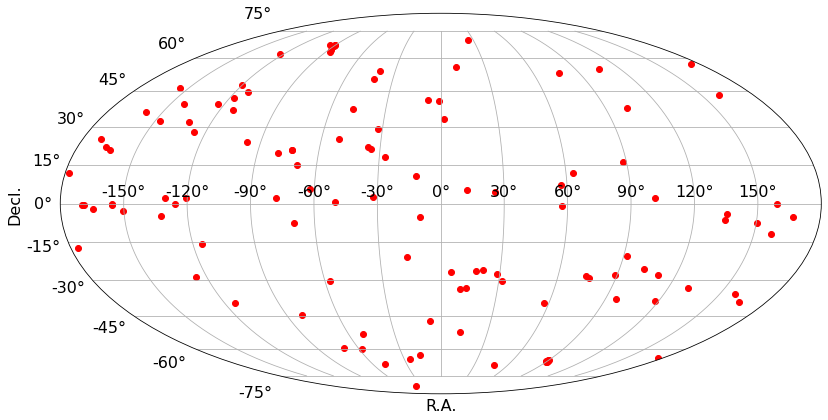

In [8]:
import matplotlib.pylab as plt
%matplotlib inline

plt.rcParams.update({'font.size': 16})

fig = plt.figure(figsize=(14,7))
ax = fig.add_subplot(111, projection='mollweide')

ra = np.radians(hdu.data['ra'])
dec = np.radians(hdu.data['dec'])

ra[ra > np.pi] = ra[ra > np.pi] - 2 * np.pi

ax.scatter(ra, dec, c='r')
ax.grid()
ax.set_xlabel('R.A.')
ax.set_ylabel('Decl.')
plt.show()

Once the file is created, you will then want to add it to the SAS where it will then be ingested into targetdb. The path for this is:

`/uufs/chpc.utah.edu/common/home/sdss50/sdsswork/target/open_fiber/`

Within this directory will be multiple folders that will version the FITS files for commissioning and open fibers. Make sure to add your FITS file to the most recent version that has not yet been ingested into targetdb.

# Creating a FPS Design

Once the carton has been added to targetdb by the target selection team, now we can create a design using targets from our spectrophotometric carton. First, we will need to query targetdb and pull targets from the relative cartons. This will inclucde pulling targets within our field from comm_spectrophoto, but we will also want to select all sky and standards as well that will be included in the design. This is done below.

In [9]:
from sdssdb.peewee.sdss5db import targetdb

# connect to targetdb
targetdb.database.connect_from_parameters(user='sdss',
                                          host='localhost',
                                          port=7500)

True

In [51]:
from peewee import *
import numpy as np

# set search radius based on field size for APO or LCO
observatory = 'APO'
if observatory == 'APO':
    r_search = 1.49
else:
    r_search = 0.95

# specify the field center and position angle
racen = 269.59
deccen = 66.55
position_angle = 40.

# specify the commissioning cartons we want to consider
# for this example, we will also specify the pk, as there are 
# multiple standard cartons
cartons = ['comm_spectrophoto', 'ops_sky_boss', 'ops_sky_apogee',
           'ops_std_boss', 'ops_std_apogee']
cartons_pk = [648, 368, 325, 530, 532]

# get all of the targets in the commissioning carton near the field center
all_skies = (targetdb.Target.select(targetdb.Target.catalogid,
                                   targetdb.Target.ra,
                                   targetdb.Target.dec,
                                   targetdb.Target.pk,
                                   targetdb.CartonToTarget.priority,
                                   targetdb.CartonToTarget.value,
                                   targetdb.Cadence.label,
                                   targetdb.Carton.carton)
                    .join(targetdb.CartonToTarget)
                    .join(targetdb.Cadence, JOIN.LEFT_OUTER)
                    .switch(targetdb.CartonToTarget)
                    .join(targetdb.Carton)
                    .where((targetdb.Carton.carton.in_(cartons)) & 
                           (targetdb.Carton.pk.in_(cartons_pk)) & 
                           (targetdb.Target.cone_search(racen, deccen, r_search))))

# grab the results
catalogid, ra, dec, target_pk, priority, value, cadences, carton = map(list, zip(*list(all_skies.tuples())))
catalogid = np.array(catalogid, dtype=np.int64)
ra = np.array(ra)
dec = np.array(dec)
target_pk = np.array(target_pk, dtype=np.int64)
priority = np.array(priority)
value = np.array(value)
carton = np.array(carton)
# specify the instrument for each target
instrument = np.zeros(len(carton), dtype='<U10')
instrument[carton == 'ops_sky_boss'] = 'BOSS'
instrument[carton == 'ops_sky_apogee'] = 'APOGEE'
instrument[carton == 'ops_std_boss'] = 'BOSS'
instrument[carton == 'ops_std_apogee'] = 'APOGEE'
instrument[carton == 'comm_spectrophoto'] = 'BOSS'

Next, we will want to create the design using using Robostrategy. To do this, we first need to estimate the x,y coordinates of the targets in the FBS plane use coordio. To do this, we will need to also specify the observation time of the design in Julian Days.

In [52]:
from coordio.utils import radec2wokxy

# specify observation time
obsTime = 2459397.5

# convert to x,y
x, y, fieldWarn, HA, PA_coordio = radec2wokxy(ra=ra,
                                              dec=dec,
                                              coordEpoch=np.array([2457174] * len(ra)),
                                              waveName=np.array(list(map(lambda x:x.title(), instrument))),
                                              raCen=racen,
                                              decCen=deccen,
                                              obsAngle=position_angle,
                                              obsSite=observatory,
                                              obsTime=obsTime)

To visualize our possible targets for the design, below is a plot of the possible targets in the FPS focal plane:

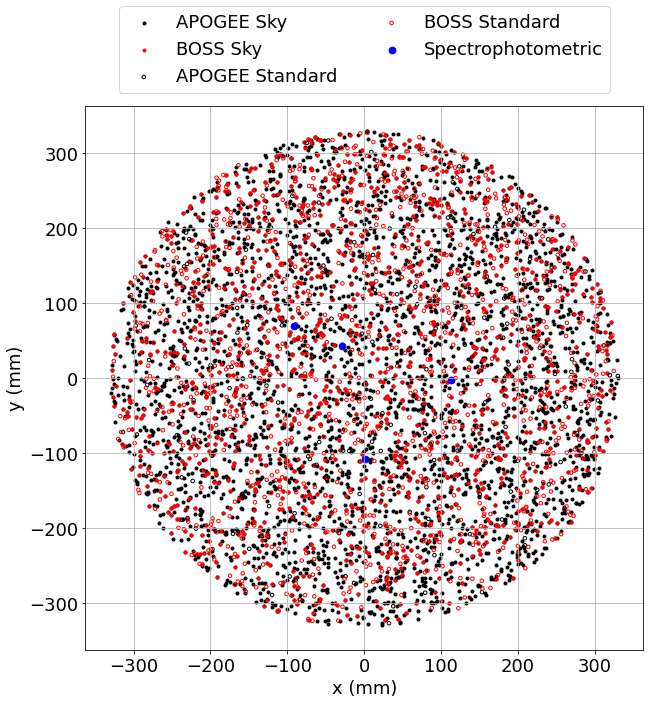

In [53]:
import matplotlib.pylab as plt
%matplotlib inline

plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(10,10))
plt.scatter(x[(instrument == 'APOGEE') & (carton == 'ops_sky_apogee')],
            y[(instrument == 'APOGEE') & (carton == 'ops_sky_apogee')],
            c='k', marker='.', label='APOGEE Sky')
plt.scatter(x[(instrument == 'BOSS') & (carton == 'ops_sky_boss')],
            y[(instrument == 'BOSS') & (carton == 'ops_sky_boss')],
            c='r', marker='.', label='BOSS Sky')
plt.scatter(x[(instrument == 'APOGEE') & (carton == 'ops_std_apogee')],
            y[(instrument == 'APOGEE') & (carton == 'ops_std_apogee')],
            edgecolors='k', marker='.', label='APOGEE Standard', facecolors='none', s=50)
plt.scatter(x[(instrument == 'BOSS') & (carton == 'ops_std_boss')],
            y[(instrument == 'BOSS') & (carton == 'ops_std_boss')],
            edgecolors='r', marker='.', label='BOSS Standard', facecolors='none', s=50)
plt.scatter(x[(instrument == 'BOSS') & (carton == 'comm_spectrophoto')],
            y[(instrument == 'BOSS') & (carton == 'comm_spectrophoto')],
            c='b', marker='.', label='Spectrophotometric', s=180)
plt.grid()
plt.legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.2))
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.show()

Before making the design, we want to make sure that the targets in our carton are higher priority than the skies and standards. So, we will force all skies and standard priorties to be lower than the nominal value from our carton of 6080.

In [54]:
priority[carton != 'comm_spectrophoto'] = 10000

Now we can build our design. This will require building arrays for the `robostrategy.field.Field` object that need to have certain formatting and datatypes. This is demonstrated above for the multi-carton design we are trying to make.

In [55]:
import robostrategy.field as field
import roboscheduler.cadence as cadence

# need to load cadences before building designs
cadence.CadenceList().fromdb()

# set cadence. must be in list of loaded cadences
# set cadence here because NONEs currently for sky carton in targetdb
cadence = 'bright_1x1'

# create the field object
f = field.Field(racen=racen, deccen=deccen, pa=position_angle,
                field_cadence=cadence, observatory=observatory.lower())

# set the required skies, in this case all fibers
f.required_calibrations['sky_boss'] = 300
f.required_calibrations['sky_apogee'] = 50
f.required_calibrations['standard_boss'] = 20
f.required_calibrations['standard_apogee'] = 20

# create array for RS field
N = len(ra)
# these are datatypes from robostrategy.Field
targets_dtype = np.dtype([('ra', np.float64),
                          ('dec', np.float64),
                          ('x', np.float64),
                          ('y', np.float64),
                          ('within', np.int32),
                          ('incadence', np.int32),
                          ('priority', np.int32),
                          ('value', np.float32),
                          ('program', np.unicode_, 30),
                          ('carton', np.unicode_, 30),
                          ('category', np.unicode_, 30),
                          ('cadence', np.unicode_, 30),
                          ('fiberType', np.unicode_, 10),
                          ('catalogid', np.int64),
                          ('rsid', np.int64),
                          ('target_pk', np.int64)])

# create an empty array
targs = np.zeros(N, dtype=targets_dtype)

# fill in the relevant columns
targs['ra'] = ra
targs['dec'] = dec
targs['x'] = x
targs['y'] = y
targs['within'] = np.zeros(N, dtype=np.int32) + 1
targs['incadence'] = np.zeros(N, dtype=np.int32) + 1
targs['priority'] = priority
targs['value'] = value
# for program and carton, these are both 'CALIBRATION' for all calibration targets (i.e. sky or standard)
# for science targets, program would be bhm/mwm/comm
program = np.zeros(N, dtype='<U30')
program[(carton == 'ops_sky_boss') | (carton == 'ops_sky_apogee') |
        (carton == 'ops_std_boss') | (carton == 'ops_std_apogee')] = 'CALIBRATION'
program[carton == 'comm_spectrophoto'] = 'comm'
targs['program'] = np.array(program, dtype='<U30')
targs['carton'] = carton
# set category. Can either be: 'sky_apogee', 'sky_boss', 'standard_apogee', 'standard_boss' or 'science'
category = np.zeros(len(carton), dtype='<U30')
category[carton == 'ops_sky_boss'] = 'sky_boss'
category[carton == 'ops_sky_apogee'] = 'sky_apogee'
category[carton == 'ops_std_boss'] = 'standard_boss'
category[carton == 'ops_std_apogee'] = 'standard_apogee'
category[carton == 'comm_spectrophoto'] = 'science'
targs['category'] = category
targs['cadence'] = np.array([cadence] * N, dtype='<U30')
targs['fiberType'] = instrument
targs['catalogid'] = catalogid
targs['rsid'] = np.arange(N, dtype=np.int64) + 1
targs['target_pk'] = target_pk

# assign targets
f.targets_fromarray(targs)

f.assign()

You can print out the results of the assigments for the design to see how close Robostrategy got to the desired design.

In [56]:
print(f.assess())

Field cadence: bright_1x1

Calibration targets:
 sky_boss (want 300): 375
 standard_boss (want 20): 20
 sky_apogee (want 50): 80
 standard_apogee (want 20): 21

Science targets:
 BOSS targets assigned: 4
 APOGEE targets assigned: 0
 Targets per epoch: 4

Carton completion:
 comm_spectrophoto: 4 of 4




As we can see from the above, we were able to add all targets in our carton in the field to the design.

You can also plot the resulting assignments:

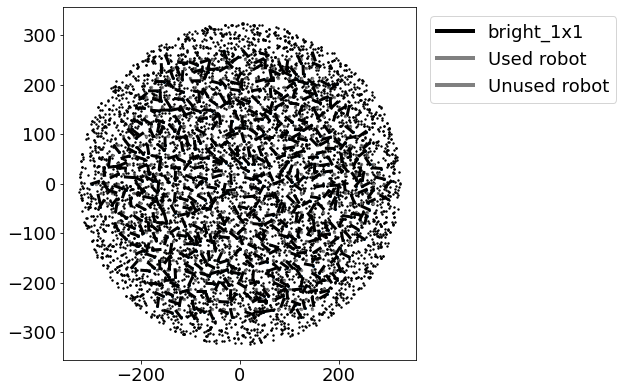

In [57]:
f.plot(iexp=0)

# Adding Commissioning Design to targetdb

Finally, if you have created a design to your liking, you can add the design to targetdb using Mugatu. To do this, we will use the results of the above design to create a mugatu.FPSDesign object. As a note, one extra bit of infromation we will need to write designs to the database is the pk of the cartons used in the design. In the cell below, we will also pull this info from the database

In [58]:
from mugatu.fpsdesign import FPSDesign

# create empty arrays for input
catalogids = np.zeros(500, dtype=np.int64) - 1
ra = np.zeros(500, dtype=float) - 9999.99
dec = np.zeros(500, dtype=float) - 9999.99
fiberID = np.zeros(500, dtype=np.int64) - 1
obsWavelength = np.zeros(500, dtype='<U10')
priority = np.zeros(500, dtype=int) - 1
carton_pk = np.zeros(500, dtype=int) - 1

# get the pks for the cartons
carton_pk_query = (targetdb.Carton.select()
                           .where((targetdb.Carton.carton.in_(cartons)) & 
                                  (targetdb.Carton.pk.in_(cartons_pk))))
cart_pks = {}
for cart in carton_pk_query:
    cart_pks[cart.carton] = cart.pk

# add assignments to the empty arrays
for i in range(len(f.targets)):
    if f.assignments[i][2][0] != -1:
        rid = f.assignments[i][2][0]
        catalogids[rid] = f.targets[i]['catalogid']
        ra[rid] = f.targets[i]['ra']
        dec[rid] = f.targets[i]['dec']
        fiberID[rid] = rid
        obsWavelength[rid] = f.targets[i]['fiberType']
        priority[rid] = f.targets[i]['priority']
        carton_pk[rid] = cart_pks[f.targets[i]['carton']]

# create a mugatu.FPSDesign object that is specified as a manual design
fps_design = FPSDesign(design_pk=-1,
                       obsTime=obsTime,
                       racen=racen,
                       deccen=deccen,
                       position_angle=position_angle,
                       observatory=observatory,
                       mode_pk=None,
                       catalogids=catalogids,
                       ra=ra,
                       dec=dec,
                       fiberID=fiberID,
                       obsWavelength=obsWavelength,
                       priority=priority,
                       carton_pk=carton_pk,
                       design_file=None,
                       manual_design=True)

Before adding the design to targetdb, we will want to validate the design one more time to ensure that there are no collisions that Robostratgegy missed:

In [59]:
fps_design.validate_design()

[WARNING]: Some targets could not be assigned to fiber (MugatuWarning)
[WARNING]: Some targets removed from design due to collisions (MugatuWarning)


Some fibers were not able to be assigned due to fibers not being able to reach targets and due to collisions. At the creating of this notebook (4/29/2021), this is due to Robostrategy not using coordio to estimate x,y coordinates during assignemnt, while mugatu does. This will be fixed in a future release of robostratgegy, which will mitigate this issue and all designs at this point from robostrategy should be completely valid.

Finally, we can add the design to targetdb using the function below. As a note, if the field you are using is not already in targetdb, make sure that the fieldid is unique.

In [60]:
fps_design.design_to_targetdb(cadence=cadence,
                              fieldid=3,
                              exposure=0)